### vangogh2novel モデル作成、保存
trainA を画像2枚にして学習を実行する、画風色調が似ている人物画2枚
100+900+3000+3000+5000+1000+10000=23000 からの続き

In [1]:
!nvidia-smi

Tue Aug 18 13:15:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Input, Dropout, Concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os

In [4]:
from glob import glob
import cv2
from matplotlib.pyplot import imread

In [5]:
DATA_DIR_PATH = '/content/drive/My Drive/kikagaku/novelgan/data'

OUTPUT_DIR_PATH = os.path.join(DATA_DIR_PATH, '18_out')

In [6]:
#os.makedirs(os.path.join(DATA_DIR_PATH, 'datasets'), exist_ok=True)

os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'images'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'saved_models'), exist_ok=True)

In [7]:
class DataLoader():
    def __init__(self, dataset_name, img_res=(256, 256)):
        self.dataset_name = dataset_name
        self.img_res = img_res
        self.datasets_path = os.path.join(DATA_DIR_PATH, 'datasets')

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        #path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))
        path = glob(os.path.join(self.datasets_path, self.dataset_name, data_type, '*'))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                #img = scipy.misc.imresize(img, self.img_res)
                img = cv2.resize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                #img = scipy.misc.imresize(img, self.img_res)
                img = cv2.resize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        #path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type))
        #path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))
        path_A = glob(os.path.join(self.datasets_path, self.dataset_name, '{}A'.format(data_type), '*'))
        path_B = glob(os.path.join(self.datasets_path, self.dataset_name, '{}B'.format(data_type), '*'))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        #for i in range(self.n_batches-1):
        for i in range(self.n_batches):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []

            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                #img_A = scipy.misc.imresize(img_A, self.img_res)
                img_A = cv2.resize(img_A, self.img_res)
                #img_B = scipy.misc.imresize(img_B, self.img_res)
                img_B = cv2.resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                    img_A = np.fliplr(img_A)
                    img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        #img = scipy.misc.imresize(img, self.img_res)
        img = cv2.resize(img, self.img_res)
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]

    def imread(self, path):
        #return scipy.misc.imread(path, mode='RGB').astype(np.float)
        return imread(path).astype(np.float)

In [8]:
IMG_ROWS = 256
IMG_COLS = 256

data_loader = DataLoader('vangogh2novel_4', img_res=(IMG_ROWS, IMG_COLS))

In [9]:
class CycleGAN:
    def __init__(self):
        self.history = pd.DataFrame({}, columns=[
            'epoch', 'epochs', 'batch_idx', 'batch_num', 'd_loss', 'acc', 'g_loss',
            'adv', 'recon', 'id', 'elapsed_time'])

        self.img_save_dir = os.path.join(OUTPUT_DIR_PATH, 'images')
        self.model_save_dir = os.path.join(OUTPUT_DIR_PATH, 'saved_models')
        self.combined_name = 'combined_model'
        self.g_AB_name = 'g_AB_model'
        self.g_BA_name = 'g_BA_model'

        self.train_cnt = 0

        # Input shape
        self.img_rows = IMG_ROWS
        self.img_cols = IMG_COLS
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.d_A = None
        self.d_B = None
        self.g_AB = None
        self.g_BA = None
        self.combined = None

    def init(self, data_loader=None):
        # Configure data loader
        #self.dataset_name = 'apple2orange'
        #self.data_loader = DataLoader(dataset_name=self.dataset_name,
        #                              img_res=(self.img_rows, self.img_cols))
        if data_loader:
            self.data_loader = data_loader
            self.dataset_name = self.data_loader.dataset_name 

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        #self.gf = 32 # U-Net, 128
        self.gf = 64
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)

        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)

        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # U-Net, 12
        ## Downsampling
        #d1 = conv2d(d0, self.gf)
        #d2 = conv2d(d1, self.gf*2)
        #d3 = conv2d(d2, self.gf*4)
        #d4 = conv2d(d3, self.gf*8)
        #
        ## Upsampling
        #u1 = deconv2d(d4, d3, self.gf*4)
        #u2 = deconv2d(u1, d2, self.gf*2)
        #u3 = deconv2d(u2, d1, self.gf)
        #
        #u4 = UpSampling2D(size=2)(u3)
        #output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=-1, save_interval=-1):
        self.train_cnt += 1

        print(datetime.datetime.now().isoformat(), 'Start', self.train_cnt)

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        step_cnt = 1

        #for epoch in range(epochs):
        for epoch in range(1, epochs+1):
            #for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size), 1):

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B,
                                                       imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                # print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " % (
                #     epoch, epochs,
                #     batch_i, self.data_loader.n_batches,
                #     d_loss[0], 100*d_loss[1],
                #     g_loss[0],
                #     np.mean(g_loss[1:3]),
                #     np.mean(g_loss[3:5]),
                #     np.mean(g_loss[5:6]),
                #     elapsed_time))
                self.history = self.history.append({
                    'epoch': epoch,
                    'epochs': epochs,
                    'batch_idx': batch_i,
                    'batch_num': self.data_loader.n_batches,
                    'd_loss': d_loss[0],
                    'acc': d_loss[1],
                    'g_loss': g_loss[0],
                    'adv': np.mean(g_loss[1:3]),
                    'recon': np.mean(g_loss[3:5]),
                    'id': np.mean(g_loss[5:6]),
                    'elapsed_time': elapsed_time
                }, ignore_index=True)

                # If at save interval => save generated image samples
                #if sample_interval > 0 and batch_i % sample_interval == 0:
                if sample_interval > 0 and step_cnt % sample_interval == 0:
                    print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " % (
                        epoch, epochs,
                        batch_i, self.data_loader.n_batches,
                        d_loss[0], 100*d_loss[1],
                        g_loss[0],
                        np.mean(g_loss[1:3]),
                        np.mean(g_loss[3:5]),
                        np.mean(g_loss[5:6]),
                        elapsed_time))

                    self.sample_images(epoch, batch_i)

                #if save_interval > 0 and batch_i != 1 and (batch_i % save_interval) == 0:
                if save_interval > 0 and step_cnt % save_interval == 0:
                    file_suffix = '{}_{}_{}'.format(self.train_cnt, epoch, batch_i)
                    self.save_model_weights(self.combined, self.combined_name, file_suffix)

                step_cnt += 1

        print(datetime.datetime.now().isoformat(), 'End')

    def generate_image_A(self, img):
        return self.g_AB.predict(img)

    def generate_image_B(self, img):
        return self.g_BA.predict(img)

    def sample_images(self, epoch, batch_i):
        dir_path = os.path.join(self.img_save_dir, self.dataset_name)

        #os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        os.makedirs(dir_path, exist_ok=True)

        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('datasets/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('datasets/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)

        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i, j].axis('off')
                cnt += 1

        #fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        file_path = os.path.join(dir_path, '{}_{}_{}.png'.format(self.train_cnt, epoch, batch_i))
        fig.savefig(file_path)

        plt.close()

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['d_loss', 'g_loss']
            #columns = ['d_loss', 'acc', 'g_loss', 'adv', 'recon', 'id',]
        self.history[columns].plot()

    def save_models(self, file_suffix=None):
        self.save_model_weights(self.combined, self.combined_name, file_suffix)
        #self.save_model_weights(self.g_AB, self.g_AB_name, file_suffix)
        #self.save_model_weights(self.g_BA, self.g_BA_name, file_suffix)

    def save_model_weights(self, model, model_name, file_suffix=None):
        file_path = os.path.join(self.model_save_dir, self._create_h5_file_name(model_name, file_suffix))
        model.save_weights(file_path)

        print('Model weights saved.', model_name)

    def load_models(self, file_suffix=None):
        self.load_model_weights(self.combined_name, file_suffix)
        self.load_model_weights(self.g_AB_name, file_suffix)
        self.load_model_weights(self.g_BA_name, file_suffix)

    def load_model_weights(self, model_name, file_suffix=None):
        model = None

        if model_name == self.combined_name:
            model = self.combined
        elif model_name == self.g_AB_name:
            model = self.g_AB
        elif model_name == self.g_BA_name:
            model = self.g_BA
        else:
            print('Unsupported.', model_name)
            return

        if not model:
            print('Not initialized.', model_name)
            return

        file_path = os.path.join(self.model_save_dir, self._create_h5_file_name(model_name, file_suffix))

        if not os.path.exists(file_path):
            print('File Not found.', model_name)
            return

        model.load_weights(file_path)

        print('Model weights loaded.', model_name)

    def _create_h5_file_name(self, model_name, suffix=None):
        if suffix:
            return '{}_{}.h5'.format(model_name, suffix)
        else:
            return '{}.h5'.format(model_name)

In [10]:
gan = CycleGAN()
gan.init(data_loader=data_loader)
gan.load_models('17_oout_7_10000_2')

Model weights loaded. combined_model
File Not found. g_AB_model
File Not found. g_BA_model


In [11]:
# Image A Count: 2, BatchSize:1, Steps: 2/1=2
gan.train(epochs=60000, batch_size=1, sample_interval=2*250, save_interval=2*1000)

2020-08-18T13:17:37.351027 Start 1
[Epoch 250/60000] [Batch 2/2] [D loss: 0.002492, acc: 100%] [G loss: 3.252234, adv: 0.995125, recon: 0.056730, id: 0.049175] time: 0:04:42.877678 
[Epoch 500/60000] [Batch 2/2] [D loss: 0.002235, acc: 100%] [G loss: 3.077176, adv: 0.986190, recon: 0.048116, id: 0.043255] time: 0:08:40.678056 
[Epoch 750/60000] [Batch 2/2] [D loss: 0.009199, acc: 100%] [G loss: 3.168179, adv: 1.031410, recon: 0.048024, id: 0.040325] time: 0:12:38.339162 
[Epoch 1000/60000] [Batch 2/2] [D loss: 0.001475, acc: 100%] [G loss: 2.921271, adv: 0.998122, recon: 0.040906, id: 0.037913] time: 0:16:35.106445 
Model weights saved. combined_model
[Epoch 1250/60000] [Batch 2/2] [D loss: 0.001139, acc: 100%] [G loss: 2.981542, adv: 1.002380, recon: 0.043188, id: 0.039264] time: 0:20:34.454806 
[Epoch 1500/60000] [Batch 2/2] [D loss: 0.001472, acc: 100%] [G loss: 2.793283, adv: 1.005165, recon: 0.034470, id: 0.035535] time: 0:24:31.825597 
[Epoch 1750/60000] [Batch 2/2] [D loss: 0.00

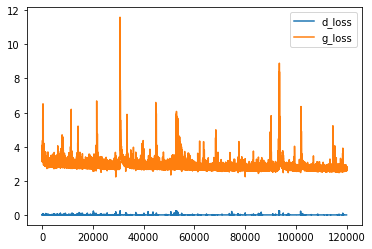

In [12]:
gan.plot_hisotry()

In [13]:
gan.history.to_csv(os.path.join(OUTPUT_DIR_PATH, 'history.csv'))